## Creation of Model Statistics DataFrame

* Student name: Greg Osborne
* Student pace: self paced / part time
* Scheduled project review date/time: 8/2/22
* Instructor name: Clause Fried
* Blog post URL: https://medium.com/@gregosborne

This Jupyter Notebook is exclusively for creating a DataFrame, and an excel file, that includes basic model data of multiple possible combinations of variables put into a model using ordinary least squares through the ModelStatistics Python library. It should be treated as a giant function rather than a presentation of the logic behind this. For that, please see the student Jupyter notebook.

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
#from itertools import combinations
#from itertools import combinations_with_replacement
from itertools import product
from itertools import permutations

plt.style.use('seaborn')
data = pd.read_csv('data/kc_house_data.csv')
pd.set_option("display.max_columns", None)

This next cell scrubs the data the same way described in the Student Jupyter Notebook.

In [2]:
#Dropping columns advised by client.
columns_to_drop = ['date', 'view', 'sqft_above', 'sqft_basement', 
                   'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
                   'sqft_lot15']
data = data.drop(columns_to_drop,axis='columns')

#Fixing Waterfront data
data.loc[data['waterfront'].isna(),'waterfront'] = 'NO'
data['waterfront'].replace({'NO':0,'YES':1},inplace=True)

#Fixing Condition data
change_numerical_condition = {'Poor' : 1, 'Fair' : 2, 'Average' : 3,
                              'Good' : 4, 'Very Good' : 5}  
data['condition'].replace(change_numerical_condition, inplace=True)

#Fixing Grade data
change_numerical_grade = {'3 Poor' : 3, '4 Low' : 4, '5 Fair' : 5,
                         '6 Low Average' : 6, '7 Average' : 7, '8 Good' : 8,
                         '9 Better' : 9, '10 Very Good' : 10, 
                         '11 Excellent' : 11, '12 Luxury' : 12,
                         '13 Mansion' : 13}

data['grade'].replace(change_numerical_grade, inplace=True)

#Dropping id column
model_data = data.drop(columns='id')

index_nums = model_data.reset_index()

#Dropping a single outlier due to bad bedroom data.
bedrooms_max = 12
bed_drop = index_nums['bedrooms'][index_nums['bedrooms']>=bedrooms_max]
model_data = index_nums.drop(index=bed_drop.index,columns='index')

These next cells create the functions to create the transformations needed for this analysis.

In [3]:
#This logs all the independent variables in the data.
def log_data(df, var,keep=False):
    order = df.columns
    df_log = pd.DataFrame()
    new_col = []
    for i in range(len(order)):
        if order[i] not in var:
            df_log[order[i]] = df[order[i]]
        else:
            new_col.append(order[i] + '_log')
            df_log[order[i] + '_log'] = df[order[i]].map(lambda x : np.log(x))
    if keep == True:
        df_new = df.copy()
        for col in new_col:
            df_new[new_col] = df_log[new_col]
        return df_new
    return df_log

In [4]:
#This performs a min-max scaling of all independent variables in the data.
def scale_data(df,var,keep=False):
    order = df.columns
    df_scale = pd.DataFrame()
    new_col = []
    for i in range(len(order)):
        if order[i] not in var:
            df_scale[order[i]] = df[order[i]]
        else:
            mn = df[order[i]].min()
            mx = df[order[i]].max()
            new_col.append(order[i] + '_scale')
            df_scale[order[i] + '_scale'] = df[
                order[i]].map(lambda x : (x-mn)/(mx-mn))
    if keep == True:
        df_new = df.copy()
        for col in new_col:
            df_new[new_col] = df_scale[new_col]
        return df_new
    return df_scale

In [5]:
#This squares all the independent variables in the data.
def sq_data(df, var,keep=False):
    order = df.columns
    df_pow2 = pd.DataFrame()
    new_col = []
    for i in range(len(order)):
        if order[i] not in var:
            df_pow2[order[i]] = df[order[i]]
        else:
            new_col.append(order[i] + '_sq')
            df_pow2[order[i] + '_sq'] = df[order[i]].map(lambda x : x**2)
    if keep == True:
        df_new = df.copy()
        for col in new_col:
            df_new[new_col] = df_pow2[new_col]
        return df_new
    return df_pow2

In [6]:
#This returns five DataFrames, one for untransformed data and one for each 
#transformation this model analyzes.
def tran_data(df,var):
    if 'waterfront' in var:
        var.remove('waterfront')
    df_scale = scale_data(df, var)
    df_log = log_data(df, var)
    df_log_scale = scale_data(df_log, 
                    list(df_log.drop(columns=['price','waterfront']).columns))
    df_sq = sq_data(df,var)
    return [df, df_scale, df_log, df_log_scale, df_sq]

Since the testing for the multicollinearity is critical to the function definitons below, I will leave this test here.

In [7]:
#This creates the initial DataFrame to be added to later.
multicollinearity_test_data = model_data.copy()

#This returns five DataFrames, one for untransformed data and one for each 
#transformation this model analyzes.
dfr,dfs,dfl,dfls,dfsq = tran_data(
    model_data,list(model_data.iloc[0:1,1:].columns))

#Getting rid of values I don't want repeated.
dfs = dfs.drop(columns=['price','waterfront'])
dfl = dfl.drop(columns=['price','waterfront'])
dfls = dfls.drop(columns=['price','waterfront'])
dfsq = dfsq.drop(columns=['price','waterfront'])

#Constructiong a large DataFrame with all raw and transformed values.
multicollinearity_test_data = pd.concat([dfr,dfs,dfl,dfls,dfsq],axis=1)
del dfr,dfs,dfl,dfls,dfsq

#Running the multicollinearity test and displaying the results.
multicollinearity_test = multicollinearity_test_data.corr()
for c in multicollinearity_test.columns:
    multicollinearity_test[c] = multicollinearity_test[c].map('{:.3f}'.format)
multicollinearity_test

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,bedrooms_scale,bathrooms_scale,sqft_living_scale,sqft_lot_scale,floors_scale,condition_scale,grade_scale,yr_built_scale,bedrooms_log,bathrooms_log,sqft_living_log,sqft_lot_log,floors_log,condition_log,grade_log,yr_built_log,bedrooms_log_scale,bathrooms_log_scale,sqft_living_log_scale,sqft_lot_log_scale,floors_log_scale,condition_log_scale,grade_log_scale,yr_built_log_scale,bedrooms_sq,bathrooms_sq,sqft_living_sq,sqft_lot_sq,floors_sq,condition_sq,grade_sq,yr_built_sq
price,1.000,0.316,0.526,0.702,0.090,0.257,0.264,0.036,0.668,0.054,0.316,0.526,0.702,0.090,0.257,0.036,0.668,0.054,0.299,0.456,0.612,0.162,0.267,0.037,0.635,0.053,0.299,0.456,0.612,0.162,0.267,0.037,0.635,0.053,0.310,0.573,0.727,0.035,0.237,0.037,0.693,0.055
bedrooms,0.316,1.000,0.528,0.593,0.034,0.184,-0.002,0.023,0.366,0.161,1.000,0.528,0.593,0.034,0.184,0.023,0.366,0.161,0.972,0.521,0.638,0.190,0.206,0.028,0.374,0.161,0.972,0.521,0.638,0.190,0.206,0.028,0.374,0.161,0.974,0.500,0.487,0.003,0.150,0.021,0.354,0.161
bathrooms,0.526,0.528,1.000,0.756,0.088,0.503,0.064,-0.126,0.666,0.507,0.528,1.000,0.756,0.088,0.503,-0.126,0.666,0.507,0.525,0.971,0.762,0.101,0.513,-0.118,0.665,0.506,0.525,0.971,0.762,0.101,0.513,-0.118,0.665,0.506,0.499,0.961,0.674,0.031,0.472,-0.126,0.657,0.509
sqft_living,0.702,0.593,0.756,1.000,0.173,0.354,0.105,-0.059,0.763,0.318,0.593,0.756,1.000,0.173,0.354,-0.059,0.763,0.318,0.581,0.708,0.955,0.345,0.377,-0.052,0.743,0.317,0.581,0.708,0.955,0.345,0.377,-0.052,0.743,0.317,0.565,0.757,0.936,0.054,0.311,-0.061,0.772,0.319
sqft_lot,0.090,0.034,0.088,0.173,1.000,-0.005,0.021,-0.009,0.115,0.053,0.034,0.088,0.173,1.000,-0.005,-0.009,0.115,0.053,0.033,0.075,0.150,0.639,0.001,-0.011,0.104,0.053,0.033,0.075,0.150,0.639,0.001,-0.011,0.104,0.053,0.031,0.099,0.178,0.788,-0.013,-0.008,0.123,0.052
floors,0.257,0.184,0.503,0.354,-0.005,1.000,0.021,-0.264,0.459,0.489,0.184,0.503,0.354,-0.005,1.000,-0.264,0.459,0.489,0.192,0.501,0.368,-0.237,0.991,-0.255,0.463,0.485,0.192,0.501,0.368,-0.237,0.991,-0.255,0.463,0.485,0.165,0.456,0.299,0.009,0.985,-0.262,0.445,0.493
waterfront,0.264,-0.002,0.064,0.105,0.021,0.021,1.000,0.017,0.083,-0.024,-0.002,0.064,0.105,0.021,0.021,0.017,0.083,-0.024,-0.008,0.047,0.079,0.072,0.021,0.015,0.073,-0.024,-0.008,0.047,0.079,0.072,0.021,0.015,0.073,-0.024,0.003,0.078,0.123,0.002,0.020,0.018,0.091,-0.025
condition,0.036,0.023,-0.126,-0.059,-0.009,-0.264,0.017,1.000,-0.147,-0.362,0.023,-0.126,-0.059,-0.009,-0.264,1.000,-0.147,-0.362,0.026,-0.113,-0.050,0.074,-0.261,0.989,-0.145,-0.360,0.026,-0.113,-0.050,0.074,-0.261,0.989,-0.145,-0.360,0.021,-0.124,-0.058,-0.004,-0.258,0.995,-0.145,-0.363
grade,0.668,0.366,0.666,0.763,0.115,0.459,0.083,-0.147,1.000,0.448,0.366,0.666,0.763,0.115,0.459,-0.147,1.000,0.448,0.381,0.644,0.743,0.184,0.468,-0.133,0.993,0.447,0.381,0.644,0.743,0.184,0.468,-0.133,0.993,0.447,0.327,0.639,0.692,0.034,0.431,-0.151,0.994,0.449
yr_built,0.054,0.161,0.507,0.318,0.053,0.489,-0.024,-0.362,0.448,1.000,0.161,0.507,0.318,0.053,0.489,-0.362,0.448,1.000,0.195,0.534,0.350,-0.007,0.475,-0.341,0.463,1.000,0.195,0.534,0.350,-0.007,0.475,-0.341,0.463,1.000,0.118,0.434,0.251,0.013,0.486,-0.367,0.426,1.000


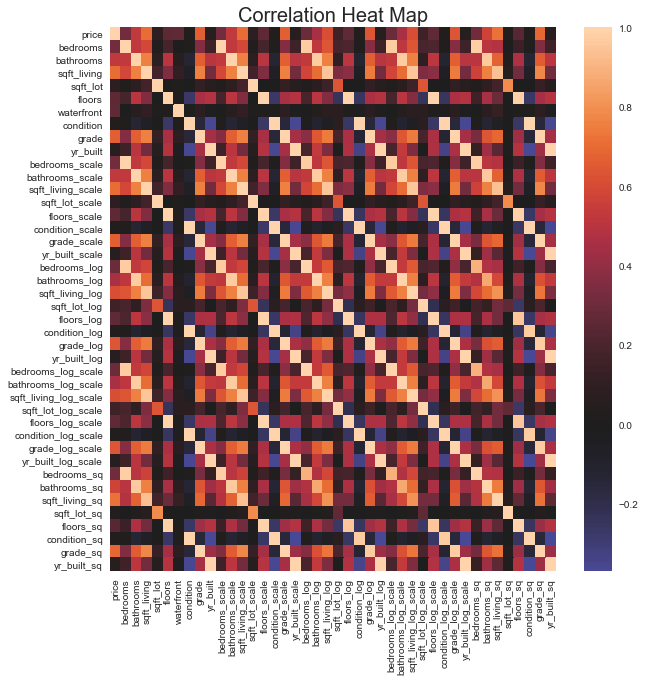

In [8]:
import seaborn as sns
plt.figure(figsize = (10,10))
heat = sns.heatmap(multicollinearity_test_data.corr(), center=0)
heat.set_title('Correlation Heat Map',size=20);

These functions provide the means to create the excel file with the model statistics needed.

In [9]:
#This function creates a model from a Pandas DataFrame and a list of variables
#to include. Price will always be the dependent variable.
def make_model(mod, lst):
    outcome = 'price'
    predictors = mod[lst]
    pred_sum = '+'.join(predictors.columns)
    formula = outcome + '~' + pred_sum
    return ols(formula=formula, data=mod).fit()

In [10]:
#This reformats the variable names into a more aesthetic format.
def new_name(var):
    rename_var = {'bedrooms' : 'Bed', 'bathrooms' : 'Bath',
        'sqft_living': 'SF Liv', 'grade' : 'Grade',
        'sqft_lot' : 'SF Lot','floors': 'Floors',
        'waterfront': 'WF' ,'condition': 'Cond',
        'yr_built' : 'Yr',
        'bedrooms_log' : 'Log(Bed)', 'bathrooms_log' : 'Log(Bath)',
        'sqft_living_log': 'Log(SF Liv)', 'grade_log' : 'Log(Grade)',
        'sqft_lot_log' : 'Log(SF Lot)','floors_log': 'Log(Floors)',
        'waterfront_log': 'Log(WF)' ,'condition_log': 'Log(Cond)',
        'yr_built_log' : 'Log(Yr)',
        'bedrooms_scale' : 'Norm Bed','bathrooms_scale':'Norm Bath',
        'sqft_living_scale':'Norm SF Liv','grade_scale':'Norm Grade',
        'sqft_lot_scale':'Norm SF Lot','floors_scale':'Norm Floors',
        'waterfront_scale': 'Norm WF' ,'condition_scale':'Norm Cond',
        'yr_built_scale' : 'Norm Yr',
        'bedrooms_log_scale':'Norm Log(Bed)',
        'bathrooms_log_scale':'Norm Log(Bath)',
        'sqft_living_log_scale':'Norm Log(SF Liv)',
        'grade_log_scale':'Norm Log(Grade)',
        'sqft_lot_log_scale':'Norm Log(SF Lot)',
        'floors_log_scale':'Norm Log(Floors)',
        'waterfront_log_scale': 'Norm Log(WF)' ,
        'condition_log_scale':'Norm Log(Cond)',
        'yr_built_log_scale' : 'Norm Log(Yr)',
        'bedrooms_sq' : 'Bed²', 'bathrooms_sq' : 'Bath²',
        'sqft_living_sq': 'SF Liv²', 'grade_sq' : 'Grade²',
        'sqft_lot_sq' : 'SF Lot²','floors_sq': 'Floors²',
        'waterfront_sq': 'WF²' ,'condition_sq': 'Cond²',
        'yr_built_sq' : 'Yr²'}
    new_var = []
    for v in var:
        new_var.append(rename_var[v])
    return new_var

In [11]:
#This returns a list of strings that identify the variables used in that
#row's model.
def model_variables(lst):
    fv = new_name(lst) #fv = fomatted variable
    if len(fv) == 1:
        text = f'{fv[0]}'
        return text
    elif len(fv) == 2:
        text = f'{fv[0]} & {fv[1]}'
        return text
    text = f'{fv[0]}, {fv[1]}, {fv[2]}'
    i = 3
    while i < len(fv):
        text = text + f', {fv[i]}'
        i += 1
    return text

In [12]:
#This formats the DataFrame's column names with better aesthetics.
def format_df(df, var):
    rename_coefficients = {'bedrooms' : 'Bed Coef', 'bathrooms' : 'Bath Coef',
        'sqft_living': 'SF Liv Coef', 'grade' : 'Grade Coef',
        'sqft_lot' : 'SF Lot Coef','floors': 'Floors Coef',
        'waterfront': 'WF Coef' ,'condition': 'Cond Coef',
        'yr_built' : 'Yr Coef',
        'bedrooms_log' : 'Log(Bed) Coef', 'bathrooms_log' : 'Log(Bath) Coef',
        'sqft_living_log': 'Log(SF Liv) Coef', 'grade_log' : 'Log(Grade) Coef',
        'sqft_lot_log' : 'Log(SF Lot) Coef','floors_log': 'Log(Floors) Coef',
        'waterfront_log': 'Log(WF) Coef' ,'condition_log': 'Log(Cond) Coef',
        'yr_built_log' : 'Log(Yr) Coef',
        'bedrooms_scale' : 'Norm Bed Coef','bathrooms_scale':'Norm Bath Coef',
        'sqft_living_scale':'Norm SF Liv Coef','grade_scale':'Norm Grade Coef',
        'sqft_lot_scale':'Norm SF Lot Coef','floors_scale':'Norm Floors Coef',
        'waterfront_scale': 'Norm WF Coef' ,'condition_scale':'Norm Cond Coef',
        'yr_built_scale' : 'Norm Yr Coef',
        'bedrooms_log_scale':'Norm Log(Bed) Coef',
        'bathrooms_log_scale':'Norm Log(Bath) Coef',
        'sqft_living_log_scale':'Norm Log(SF Liv) Coef',
        'grade_log_scale':'Norm Log(Grade) Coef',
        'sqft_lot_log_scale':'Norm Log(SF Lot) Coef',
        'floors_log_scale':'Norm Log(Floors) Coef',
        'waterfront_log_scale': 'Norm Log(WF) Coef' ,
        'condition_log_scale':'Norm Log(Cond) Coef',
        'yr_built_log_scale' : 'Norm Log(Yr) Coef',
        'bedrooms_sq' : 'Bed² Coef', 'bathrooms_sq' : 'Bath² Coef',
        'sqft_living_sq': 'SF Liv² Coef', 'grade_sq' : 'Grade² Coef',
        'sqft_lot_sq' : 'SF Lot² Coef','floors_sq': 'Floors² Coef',
        'waterfront_sq': 'WF² Coef' ,'condition_sq': 'Cond² Coef',
        'yr_built_sq' : 'Yr² Coef'}
    
    df['R²'] = df['R²'].map('{:.3f}'.format)
    df['P-value'] = df['P-value'].map('{:.1f}'.format)
    df['Intercept'] = df['Intercept'].map('{:.0f}'.format)
    for v in var:
        if v in df.columns:
            df[v] = df[v].map('{:.2f}'.format)
    floats = list(df.iloc[:,1:].columns)
    for obj in floats:
        df[obj] = df[obj].astype(float)

    df = df.rename(columns = rename_coefficients)
    return df

In [13]:
#Splitting the DataFrame parameter into individual DataFrames, each all the
#same variable with all the applicable applications.
def var_tran_dfs(df):
    drop = ['price','waterfront']
    var = list(df.drop(columns=drop).columns)
    num = len(var) + 1
    dfr,dfs,dfl,dfls,dfsq = tran_data(df,var)
    dfp,dfbd,dfbt,dflv,dflt,dffl,dfwf,dfct,dfgd,dfyb=0,0,0,0,0,0,0,0,0,0
    create_dfs = [dfp,dfbd,dfbt,dflv,dflt,dffl,dfwf,dfct,dfgd,dfyb]
    for i in range(len(df.columns)):
        create_dfs[i] = pd.DataFrame()
        for dfi in [dfr,dfs,dfl,dfls,dfsq]:
            create_dfs[i][dfi.iloc[:,i].name] = dfi.iloc[:,i]
    iter_df = []
    static_df = []
    static_df_num = [0]
    for i in range(len(create_dfs)):
        if i in static_df_num:
            static_df.append(create_dfs[i])
        else:
            iter_df.append(create_dfs[i])
    return static_df, iter_df

In [14]:
#This creates the DataFrame with the included model's pertinent statistics.
def model_stats(df,var):
    #A DataFrame to sort the outcomes and make it look pretty.
    dfr = pd.DataFrame(columns =['Model Variable(s)',
                               'R²','P-value','Neg Coef?'])
    
    neg = False
    
    #Running StatsModels
    m = make_model(df,var)
    
    #Testing to see if this model meets the requirements. The function returns 
    #an empty DataFrame if it does not.
    d = dict(m.params)
    if m.rsquared <= 0.54:
        return dfr
    for v in var:
        if d[v] < 0:
            neg = True
            return dfr
        
    #Building the DataFrame to return.
    d.update({'Model Variable(s)' : model_variables(var),
              'R²' : m.rsquared,'P-value' : m.f_pvalue,
              'Neg Coef?' : neg})
    dfr = dfr.append(d,ignore_index = True)
    
    #Formatting the DataFrame to return.
    dfr = format_df(dfr,var)
    dfr['Neg Coef?'] = dfr['Neg Coef?'].astype(bool)

    return dfr

In [15]:
#This runs thousands of models, with the specified number of variables per 
#model and returns a DataFrame with the pertinent statistics.
def mega_models(df,beg,end):
    
    #Variable declaration
    #Variable that keeps a list of the column names of each df iteration.
    check = []
    #Variables related to printing text to provide feedback to the user to 
    #ensure the function is still running.
    skip = False
    skip_count = 0
    discarded_models = 0
    cnt_var = 0
    cur_var = beg
    #Creating an empty list of DataFrames (dfs) that I will use to build each
    #iteration of the DataFrames in the for loop below.
    dfs = [None,None,None,None,None,None,None,None,None]

    #Splitting the DataFrame parameter into individual DataFrames, each all the
    #same variable with all the applicable applications.
    dep_df, ind_df =var_tran_dfs(df)
    
    #Creating the DataFrame with the columns in an order that makes sense.
    dfr_col = ['Model Variable(s)','R²','P-value','Neg Coef?','Intercept']
    for i in range(len(ind_df[0].columns)):
        for df_temp in ind_df:
            if i > len(df_temp.columns)-1:
                continue
            else:
                dfr_col.append(df_temp.iloc[:,i].name)
    dfr = pd.DataFrame(columns=dfr_col)
    dfr = format_df(dfr, dfr_col)
    dfr['Neg Coef?'] = dfr['Neg Coef?'].astype(bool)
    
    #Creating dictionary of combinations. The key is the number of variables
    #per iteration, and the value is a list of which variables to include.
    num_var = dict(zip([0,1,2,3,4,5,6,7,8,9],
                  [[],[],[],[],[],[],[],[],[],[]]))
    for lst in product(range(2),repeat=9):
        num_var[sum(lst)].append(lst)
    
    #This for loop is the major work of this function. It creates a DataFrame
    #with pertinent information on different combinations of variables
    #specified in the parameters.
    for num in range(beg,end+1):
        
        #Prints feedback text so the user knows the program is running.
        cnt_var += 1
        print(f'Combos of {cur_var} variables ({cnt_var}/{end-beg+1}).')
        cur_var += 1
        
        #Resetting count variables related to each combination of variables
        model_count = 0
        skipped = 0
        
        #Calculating the total number of iterations for this combination of
        #variables.
        var_tot_iter = len(num_var[num])*len(list(product(
            range(len(ind_df[0].columns)),repeat=num)))
        
        #This first for loop iterates through the combinations of which
        #variables to include in the current interation.
        for vars_used in num_var[num]:
            #The second for loop specifies which transformations to use for
            #the current iteration.
            for tran_nums in product(range(len(ind_df[0].columns)),repeat=num):
                i,j,=0,0 #Specifies iteration of transformation.
                
                #Prints feedback so the user knows the program is running.
                #if ten thousand DataFrames are skipped, it prints this.
                if skip == True:
                    skip_count += 1
                    if skip_count % 10000 == 0:
                        print(f'Model {model_count} of {var_tot_iter}.')
                #If the program completed a thousand DataFrame iterations:
                if skip == False:
                    if model_count % 1000 == 0:
                        print(f'Model {model_count} of {var_tot_iter}.')
                        skip_count = 0
                        
                #Sets a list of which variables are used to check if the
                #the current iteration is a repeat.
                check_iter = []
                
                #Checks if current iteration includes variables that are
                #I previously learned are multicollinear. This portion of code
                #doesn't check for multicollinearity, but rather filters out
                #variables I previously tested positive for multicollinearity.
                if vars_used[2] == 1:
                    if vars_used[1] == 1 or vars_used[7] == 1:
                        #This function returns True or False whether the 
                        #values are multicollinear.
                        if multi_corr(vars_used,tran_nums):
                            skip=True
                            skipped += 1
                            var_tot_iter -= 1
                            continue
                            
                #This creates the list of DataFrames for this iteration.
                for var in vars_used:
                    if var == 1:
                        if i == 5:
                            dfs[i] = ind_df[i].copy()
                            check_iter.append(var)
                        else:
                            dfs[i] = ind_df[i].iloc[:,tran_nums[j]].copy()
                            check_iter.append([var,tran_nums[j]])
                        i+=1
                        j+=1
                        
                    #This creates the list to check if this iteration 
                    #is a repeat.
                    else:
                        dfs[i]=None
                        check_iter.append(var)
                        i+=1
                
                #If the iteration is a repeat, this skips the model creation,
                #which saves time to run the function. Otherwise, the iteration
                #list is added to the check list to be filtered out later.
                if check_iter in check:
                    skip=True
                    skipped += 1
                    var_tot_iter -= 1
                    continue
                else:
                    check.append(check_iter)
                    
                #This puts the gleaned variables together into one DataFrame.
                iter_df = pd.concat([dep_df[0],dfs[0],dfs[1],dfs[2],
                                     dfs[3],dfs[4],dfs[5],dfs[6],
                                     dfs[7],dfs[8],],axis = 1)
                
                #And finally, the program runs the iteration through 
                #StatsModels, and creates a DataFrame of the critical 
                #statistics.
                col = list(iter_df.iloc[:,1:].columns)
                dfr_temp = model_stats(iter_df,col)
                model_count += 1 #We have successfully created a model.
                skip=False #We didn't skip this iteration.
                
                #The model_stats function will return a an empty DataFrame if
                #the model's data didn't meet certain requirements.
                if dfr_temp.empty:
                    discarded_models += 1
                    continue
                    
                #DataFrame statistics is now added to the DataFrame to return.
                dfr = dfr.append(dfr_temp, ignore_index=True)
    
    #Ending text to confirm the function performed correctly.
    print(f'Model {model_count} of {var_tot_iter}.',
         f'Skipped {skipped} iterations.')
    print(f'{discarded_models} models discarded due to',
          'low R² or negative coefficients.')
    print(len(dfr), 'Models met minimum requirements.')
    
    #Organizing the DataFrame to return.
    dfr = dfr.sort_values('R²',ascending=False)
    dfr = dfr.reset_index(drop=True)
    return dfr

In [16]:
#This tests if the current iteration is multicollinear. It returns a boolean.
def multi_corr(var_tup,tran_tup):
    #Variable declaration
    detected = False
    var_lst = []
    
    #This creates a list of which variables are included and which 
    #transformation form it is in.
    i=0
    for n in range(9):
        var_lst.append(var_tup[n] - 1)
        if var_lst[n] == 0:
            var_lst[n] = tran_tup[i]
            i+=1
            
    #These two if loops test if the combination of variables match the
    #previously calculated multicollinear pairs.
    if var_lst[2] in [0,1]:
        if var_lst[1] in [0,1,4] or var_lst[7] in [0,1,4]:
            detected = True
            return detected
    if var_lst[2] in [2,3]:
        if var_lst[1] in [0,1,2,3]:
            detected = True    
    
    return detected

In [17]:
mega1 = mega_models(model_data,1,1)
mega1 

Combos of 1 variables (1/1).
Model 0 of 45.
Model 41 of 41. Skipped 4 iterations.
41 models discarded due to low R² or negative coefficients.
0 Models met minimum requirements.


,Model Variable(s),R²,P-value,Neg Coef?,Intercept,Bed Coef,Bath Coef,SF Liv Coef,SF Lot Coef,Floors Coef,WF Coef,Cond Coef,Grade Coef,Yr Coef,Norm Bed Coef,Norm Bath Coef,Norm SF Liv Coef,Norm SF Lot Coef,Norm Floors Coef,Norm Cond Coef,Norm Grade Coef,Norm Yr Coef,Log(Bed) Coef,Log(Bath) Coef,Log(SF Liv) Coef,Log(SF Lot) Coef,Log(Floors) Coef,Log(Cond) Coef,Log(Grade) Coef,Log(Yr) Coef,Norm Log(Bed) Coef,Norm Log(Bath) Coef,Norm Log(SF Liv) Coef,Norm Log(SF Lot) Coef,Norm Log(Floors) Coef,Norm Log(Cond) Coef,Norm Log(Grade) Coef,Norm Log(Yr) Coef,Bed² Coef,Bath² Coef,SF Liv² Coef,SF Lot² Coef,Floors² Coef,Cond² Coef,Grade² Coef,Yr² Coef


There were no single variable models that met the requirements.

In [18]:
mega2 = mega_models(model_data,2,2)
mega2 

Combos of 2 variables (1/1).
Model 0 of 900.
Model 720 of 720. Skipped 180 iterations.
714 models discarded due to low R² or negative coefficients.
6 Models met minimum requirements.


,Model Variable(s),R²,P-value,Neg Coef?,Intercept,Bed Coef,Bath Coef,SF Liv Coef,SF Lot Coef,Floors Coef,WF Coef,Cond Coef,Grade Coef,Yr Coef,Norm Bed Coef,Norm Bath Coef,Norm SF Liv Coef,Norm SF Lot Coef,Norm Floors Coef,Norm Cond Coef,Norm Grade Coef,Norm Yr Coef,Log(Bed) Coef,Log(Bath) Coef,Log(SF Liv) Coef,Log(SF Lot) Coef,Log(Floors) Coef,Log(Cond) Coef,Log(Grade) Coef,Log(Yr) Coef,Norm Log(Bed) Coef,Norm Log(Bath) Coef,Norm Log(SF Liv) Coef,Norm Log(SF Lot) Coef,Norm Log(Floors) Coef,Norm Log(Cond) Coef,Norm Log(Grade) Coef,Norm Log(Yr) Coef,Bed² Coef,Bath² Coef,SF Liv² Coef,SF Lot² Coef,Floors² Coef,Cond² Coef,Grade² Coef,Yr² Coef
0,SF Liv² & Grade²,0.588,0.0,False,-29632.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,6715.75,NaN
1,SF Liv² & Grade,0.581,0.0,False,-396479.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98988.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,NaN,NaN
2,SF Liv² & Norm Grade,0.581,0.0,False,-99514.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,989883.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,NaN,NaN
3,SF Liv² & Log(Grade),0.573,0.0,False,-1035517.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,683759.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN,NaN
4,SF Liv² & Norm Log(Grade),0.573,0.0,False,-284330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1002622.59,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN,NaN
5,SF Liv² & WF,0.560,0.0,False,287040.0,NaN,NaN,NaN,NaN,NaN,795513.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN


In [19]:
mega3 = mega_models(model_data,3,3)
mega3 

Combos of 3 variables (1/1).
Model 0 of 10500.
Model 1000 of 9900.
Model 2000 of 9134.
Model 3000 of 8874.
Model 4000 of 8374.
Model 5000 of 7598.
Model 6000 of 7368.
Model 7000 of 7168.
Model 7098 of 7098. Skipped 3402 iterations.
7046 models discarded due to low R² or negative coefficients.
52 Models met minimum requirements.


,Model Variable(s),R²,P-value,Neg Coef?,Intercept,Bed Coef,Bath Coef,SF Liv Coef,SF Lot Coef,Floors Coef,WF Coef,Cond Coef,Grade Coef,Yr Coef,Norm Bed Coef,Norm Bath Coef,Norm SF Liv Coef,Norm SF Lot Coef,Norm Floors Coef,Norm Cond Coef,Norm Grade Coef,Norm Yr Coef,Log(Bed) Coef,Log(Bath) Coef,Log(SF Liv) Coef,Log(SF Lot) Coef,Log(Floors) Coef,Log(Cond) Coef,Log(Grade) Coef,Log(Yr) Coef,Norm Log(Bed) Coef,Norm Log(Bath) Coef,Norm Log(SF Liv) Coef,Norm Log(SF Lot) Coef,Norm Log(Floors) Coef,Norm Log(Cond) Coef,Norm Log(Grade) Coef,Norm Log(Yr) Coef,Bed² Coef,Bath² Coef,SF Liv² Coef,SF Lot² Coef,Floors² Coef,Cond² Coef,Grade² Coef,Yr² Coef
0,"SF Liv², WF, Grade²",0.619,0.0,False,-26515.0,NaN,NaN,NaN,NaN,NaN,791493.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,6698.01,NaN
1,"SF Liv², WF, Grade",0.612,0.0,False,-395900.0,NaN,NaN,NaN,NaN,NaN,798901.88,NaN,99239.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,NaN,NaN
2,"SF Liv², WF, Norm Grade",0.612,0.0,False,-98181.0,NaN,NaN,NaN,NaN,NaN,798901.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,992396.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,NaN,NaN
3,"SF Liv², WF, Log(Grade)",0.605,0.0,False,-1043976.0,NaN,NaN,NaN,NaN,NaN,804722.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,689344.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN,NaN
4,"SF Liv², WF, Norm Log(Grade)",0.605,0.0,False,-286654.0,NaN,NaN,NaN,NaN,NaN,804722.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1010811.83,NaN,NaN,NaN,0.04,NaN,NaN,NaN,NaN,NaN
5,"SF Liv², Cond², Grade²",0.602,0.0,False,-164589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,9016.45,7224.86,NaN
6,"SF Liv², Norm Cond, Grade²",0.602,0.0,False,-214731.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265668.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,7199.53,NaN
7,"SF Liv², Cond, Grade²",0.602,0.0,False,-281149.0,NaN,NaN,NaN,NaN,NaN,NaN,66417.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,7199.53,NaN
8,"SF Liv², Log(Cond), Grade²",0.600,0.0,False,-323805.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225240.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,7134.40,NaN
9,"SF Liv², Norm Log(Cond), Grade²",0.600,0.0,False,-323805.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,362511.18,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,7134.40,NaN


In [20]:
mega4 = mega_models(model_data,4,4)
mega4

Combos of 4 variables (1/1).
Model 0 of 78750.
Model 1000 of 77350.
Model 2000 of 75850.
Model 3000 of 75250.
Model 4000 of 75250.
Model 5000 of 72870.
Model 6000 of 71890.
Model 7000 of 70570.
Model 8000 of 70060.
Model 9000 of 68420.
Model 10000 of 68230.
Model 11000 of 67730.
Model 12000 of 66230.
Model 13000 of 66230.
Model 14000 of 65170.
Model 15000 of 64730.
Model 16000 of 64670.
Model 17000 of 63230.
Model 18000 of 63230.
Model 19000 of 61560.
Model 20000 of 58394.
Model 21000 of 56228.
Model 22000 of 55228.
Model 23000 of 54628.
Model 24000 of 54628.
Model 25000 of 53128.
Model 26000 of 53128.
Model 27000 of 51628.
Model 28000 of 51628.
Model 29000 of 51008.
Model 30000 of 50888.
Model 31000 of 49298.
Model 32000 of 49148.
Model 33000 of 48648.
Model 34000 of 48498.
Model 35000 of 47998.
Model 36000 of 47998.
Model 37000 of 46998.
Model 38000 of 46498.
Model 39000 of 46494.
Model 40000 of 45998.
Model 41000 of 45994.
Model 42000 of 45168.
Model 43000 of 43258.
Model 43118 of 4

,Model Variable(s),R²,P-value,Neg Coef?,Intercept,Bed Coef,Bath Coef,SF Liv Coef,SF Lot Coef,Floors Coef,WF Coef,Cond Coef,Grade Coef,Yr Coef,Norm Bed Coef,Norm Bath Coef,Norm SF Liv Coef,Norm SF Lot Coef,Norm Floors Coef,Norm Cond Coef,Norm Grade Coef,Norm Yr Coef,Log(Bed) Coef,Log(Bath) Coef,Log(SF Liv) Coef,Log(SF Lot) Coef,Log(Floors) Coef,Log(Cond) Coef,Log(Grade) Coef,Log(Yr) Coef,Norm Log(Bed) Coef,Norm Log(Bath) Coef,Norm Log(SF Liv) Coef,Norm Log(SF Lot) Coef,Norm Log(Floors) Coef,Norm Log(Cond) Coef,Norm Log(Grade) Coef,Norm Log(Yr) Coef,Bed² Coef,Bath² Coef,SF Liv² Coef,SF Lot² Coef,Floors² Coef,Cond² Coef,Grade² Coef,Yr² Coef
0,"SF Liv², WF, Cond², Grade²",0.632,0.0,False,-156463.0,NaN,NaN,NaN,NaN,NaN,778168.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,8678.32,7188.33,NaN
1,"SF Liv², WF, Cond, Grade²",0.631,0.0,False,-268789.0,NaN,NaN,NaN,NaN,NaN,778932.53,63963.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,7164.20,NaN
2,"SF Liv², WF, Norm Cond, Grade²",0.631,0.0,False,-204826.0,NaN,NaN,NaN,NaN,NaN,778932.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255854.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,7164.20,NaN
3,"SF Liv², WF, Norm Log(Cond), Grade²",0.630,0.0,False,-310505.0,NaN,NaN,NaN,NaN,NaN,780897.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,349910.44,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,7102.34,NaN
4,"SF Liv², WF, Log(Cond), Grade²",0.630,0.0,False,-310505.0,NaN,NaN,NaN,NaN,NaN,780897.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,217411.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,7102.34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,"Bath², SF Liv², Log(Floors), Log(Cond)",0.540,0.0,False,28227.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50434.12,187438.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6679.23,0.05,NaN,NaN,NaN,NaN,NaN
282,"Bath², SF Liv², Norm Floors, Norm Log(Cond)",0.540,0.0,False,26842.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86661.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,303894.16,NaN,NaN,NaN,6529.46,0.05,NaN,NaN,NaN,NaN,NaN
283,"Bath², SF Liv², Norm Floors, Log(Cond)",0.540,0.0,False,26842.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86661.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188820.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6529.46,0.05,NaN,NaN,NaN,NaN,NaN
284,"Bath², SF Liv², Floors, Norm Log(Cond)",0.540,0.0,False,-7823.0,NaN,NaN,NaN,NaN,34664.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,303894.16,NaN,NaN,NaN,6529.46,0.05,NaN,NaN,NaN,NaN,NaN


In [21]:
mega5 = mega_models(model_data,5,5)
mega5

Combos of 5 variables (1/1).
Model 0 of 393750.
Model 1000 of 390250.
Model 2000 of 388750.
Model 3000 of 388750.
Model 4000 of 388750.
Model 5000 of 386350.
Model 6000 of 382350.
Model 7000 of 378185.
Model 8000 of 377850.
Model 9000 of 377850.
Model 10000 of 373600.
Model 11000 of 369560.
Model 12000 of 369300.
Model 13000 of 369300.
Model 14000 of 364850.
Model 15000 of 360935.
Model 16000 of 360750.
Model 17000 of 360750.
Model 18000 of 360750.
Model 19000 of 360750.
Model 20000 of 360750.
Model 21000 of 360000.
Model 22000 of 360000.
Model 23000 of 358020.
Model 24000 of 353270.
Model 25000 of 349850.
Model 26000 of 349850.
Model 27000 of 349850.
Model 28000 of 349850.
Model 29000 of 345850.
Model 30000 of 342350.
Model 31000 of 342350.
Model 32000 of 342350.
Model 33000 of 342350.
Model 34000 of 338350.
Model 35000 of 334850.
Model 36000 of 334850.
Model 37000 of 334850.
Model 38000 of 334850.
Model 39000 of 334850.
Model 40000 of 334850.
Model 41000 of 334850.
Model 42000 of 334

,Model Variable(s),R²,P-value,Neg Coef?,Intercept,Bed Coef,Bath Coef,SF Liv Coef,SF Lot Coef,Floors Coef,WF Coef,Cond Coef,Grade Coef,Yr Coef,Norm Bed Coef,Norm Bath Coef,Norm SF Liv Coef,Norm SF Lot Coef,Norm Floors Coef,Norm Cond Coef,Norm Grade Coef,Norm Yr Coef,Log(Bed) Coef,Log(Bath) Coef,Log(SF Liv) Coef,Log(SF Lot) Coef,Log(Floors) Coef,Log(Cond) Coef,Log(Grade) Coef,Log(Yr) Coef,Norm Log(Bed) Coef,Norm Log(Bath) Coef,Norm Log(SF Liv) Coef,Norm Log(SF Lot) Coef,Norm Log(Floors) Coef,Norm Log(Cond) Coef,Norm Log(Grade) Coef,Norm Log(Yr) Coef,Bed² Coef,Bath² Coef,SF Liv² Coef,SF Lot² Coef,Floors² Coef,Cond² Coef,Grade² Coef,Yr² Coef
0,"Bath², SF Liv², WF, Cond², Grade²",0.632,0.0,False,-157416.0,NaN,NaN,NaN,NaN,NaN,778702.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,965.12,0.03,NaN,NaN,8719.41,7147.57,NaN
1,"Bath², SF Liv², WF, Cond, Grade²",0.631,0.0,False,-270388.0,NaN,NaN,NaN,NaN,NaN,779482.03,64293.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,991.70,0.03,NaN,NaN,NaN,7122.35,NaN
2,"Bath², SF Liv², WF, Norm Cond, Grade²",0.631,0.0,False,-206094.0,NaN,NaN,NaN,NaN,NaN,779482.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,257175.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,991.70,0.03,NaN,NaN,NaN,7122.35,NaN
3,"Bath², SF Liv², WF, Log(Cond), Grade²",0.630,0.0,False,-312169.0,NaN,NaN,NaN,NaN,NaN,781395.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,218448.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,886.31,0.03,NaN,NaN,NaN,7064.71,NaN
4,"Bath², SF Liv², WF, Norm Log(Cond), Grade²",0.630,0.0,False,-312169.0,NaN,NaN,NaN,NaN,NaN,781395.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,351578.79,NaN,NaN,NaN,886.31,0.03,NaN,NaN,NaN,7064.71,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,"Norm Log(Bed), SF Lot², WF, Cond, Grade²",0.540,0.0,False,-569304.0,NaN,NaN,NaN,NaN,NaN,901755.82,72979.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162797.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,12903.71,NaN
556,"Log(Bath), SF Lot², WF, Cond², Grade²",0.540,0.0,False,-385095.0,NaN,NaN,NaN,NaN,NaN,892155.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45039.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,10333.99,12731.01,NaN
557,"Log(Bed), SF Lot, WF, Cond, Grade²",0.540,0.0,False,-569363.0,NaN,NaN,NaN,0.02,NaN,901583.35,72981.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67755.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12906.55,NaN
558,"Norm Log(Bed), SF Lot², WF, Norm Cond, Grade²",0.540,0.0,False,-496325.0,NaN,NaN,NaN,NaN,NaN,901755.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,291918.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162797.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,12903.71,NaN


In [22]:
mega6 = mega_models(model_data,6,6)
mega6

Combos of 6 variables (1/1).
Model 0 of 1312500.
Model 1000 of 1309000.
Model 2000 of 1305000.
Model 3000 of 1301000.
Model 4000 of 1293250.
Model 5000 of 1289250.
Model 6000 of 1281505.
Model 7000 of 1277500.
Model 8000 of 1273310.
Model 9000 of 1271810.
Model 10000 of 1270310.
Model 11000 of 1269750.
Model 12000 of 1269750.
Model 13000 of 1269750.
Model 14000 of 1269750.
Model 15000 of 1269750.
Model 16000 of 1269750.
Model 17000 of 1269750.
Model 18000 of 1269750.
Model 19000 of 1269750.
Model 20000 of 1266980.
Model 21000 of 1261100.
Model 22000 of 1257100.
Model 23000 of 1253100.
Model 24000 of 1249100.
Model 25000 of 1245100.
Model 26000 of 1237350.
Model 27000 of 1233350.
Model 28000 of 1229750.
Model 29000 of 1225750.
Model 30000 of 1221750.
Model 31000 of 1217750.
Model 32000 of 1213750.
Model 33000 of 1209750.
Model 34000 of 1205750.
Model 35000 of 1205750.
Model 36000 of 1205750.
Model 37000 of 1205750.
Model 38000 of 1205750.
Model 39000 of 1205750.
Model 40000 of 1205750.


Model 330000 of 641130.
Model 331000 of 639150.
Model 332000 of 637100.
Model 333000 of 635550.
Model 334000 of 634000.
Model 335000 of 631950.
Model 335780 of 621950.
Model 336000 of 618985.
Model 336950 of 608985.
Model 337000 of 608350.
Model 337845 of 598350.
Model 338000 of 596230.
Model 339000 of 587200.
Model 340000 of 585435.
Model 341000 of 583500.
Model 342000 of 581450.
Model 343000 of 579900.
Model 344000 of 577850.
Model 345000 of 576600.
Model 346000 of 575350.
Model 347000 of 573850.
Model 348000 of 573100.
Model 349000 of 571600.
Model 350000 of 570100.
Model 351000 of 568600.
Model 352000 of 567050.
Model 353000 of 565500.
Model 354000 of 563450.
Model 355000 of 561400.
Model 356000 of 559350.
Model 357000 of 551020.
Model 357860 of 541020.
Model 358000 of 539420.
Model 358710 of 529420.
Model 359000 of 526520.
Model 359995 of 516520.
Model 360000 of 516520.
Model 361000 of 514250.
Model 362000 of 512200.
Model 363000 of 510150.
Model 364000 of 508100.
Model 365000 of 

,Model Variable(s),R²,P-value,Neg Coef?,Intercept,Bed Coef,Bath Coef,SF Liv Coef,SF Lot Coef,Floors Coef,WF Coef,Cond Coef,Grade Coef,Yr Coef,Norm Bed Coef,Norm Bath Coef,Norm SF Liv Coef,Norm SF Lot Coef,Norm Floors Coef,Norm Cond Coef,Norm Grade Coef,Norm Yr Coef,Log(Bed) Coef,Log(Bath) Coef,Log(SF Liv) Coef,Log(SF Lot) Coef,Log(Floors) Coef,Log(Cond) Coef,Log(Grade) Coef,Log(Yr) Coef,Norm Log(Bed) Coef,Norm Log(Bath) Coef,Norm Log(SF Liv) Coef,Norm Log(SF Lot) Coef,Norm Log(Floors) Coef,Norm Log(Cond) Coef,Norm Log(Grade) Coef,Norm Log(Yr) Coef,Bed² Coef,Bath² Coef,SF Liv² Coef,SF Lot² Coef,Floors² Coef,Cond² Coef,Grade² Coef,Yr² Coef
0,"Bath², Norm Log(SF Liv), SF Lot², WF, Cond², G...",0.571,0.0,False,-414583.0,NaN,NaN,NaN,NaN,NaN,869019.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,370472.35,NaN,NaN,NaN,NaN,NaN,NaN,16702.86,NaN,0.0,NaN,10111.46,9562.10,NaN
1,"Bath², Log(SF Liv), SF Lot², WF, Cond, Grade²",0.571,0.0,False,-1153266.0,NaN,NaN,NaN,NaN,NaN,870053.05,74589.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102729.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16770.44,NaN,0.0,NaN,NaN,9539.57,NaN
2,"Bath², Log(SF Liv), SF Lot², WF, Norm Cond, Gr...",0.571,0.0,False,-1078677.0,NaN,NaN,NaN,NaN,NaN,870053.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,298356.90,NaN,NaN,NaN,NaN,102729.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16770.44,NaN,0.0,NaN,NaN,9539.57,NaN
3,"Bath², Norm Log(SF Liv), SF Lot², WF, Norm Con...",0.571,0.0,False,-471188.0,NaN,NaN,NaN,NaN,NaN,870053.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,298356.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,369814.41,NaN,NaN,NaN,NaN,NaN,NaN,16770.44,NaN,0.0,NaN,NaN,9539.57,NaN
4,"Bath², Norm Log(SF Liv), SF Lot², WF, Cond, Gr...",0.571,0.0,False,-545777.0,NaN,NaN,NaN,NaN,NaN,870053.05,74589.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,369814.41,NaN,NaN,NaN,NaN,NaN,NaN,16770.44,NaN,0.0,NaN,NaN,9539.57,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,"Norm Log(Bed), Norm Log(Bath), SF Lot², WF, Co...",0.541,0.0,False,-576724.0,NaN,NaN,NaN,NaN,NaN,900920.84,73776.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132692.19,69589.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,12655.35,NaN
501,"Norm Log(Bed), Norm Log(Bath), SF Lot², WF, No...",0.541,0.0,False,-502948.0,NaN,NaN,NaN,NaN,NaN,900920.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,295104.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132692.19,69589.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,12655.35,NaN
502,"Norm Log(Bed), Norm Log(Bath), SF Lot², WF, Co...",0.541,0.0,False,-447267.0,NaN,NaN,NaN,NaN,NaN,899784.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133151.32,68745.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,10043.60,12676.74,NaN
503,"Norm Bed, Bath², Norm SF Lot, WF, Norm Log(Con...",0.541,0.0,False,-1137075.0,NaN,NaN,NaN,NaN,NaN,900448.27,NaN,159937.88,NaN,12695.64,NaN,NaN,58780.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,425767.54,NaN,NaN,NaN,24252.16,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
mega7 = mega_models(model_data,7,7)
mega7

Combos of 7 variables (1/1).
Model 0 of 2812500.
Model 900 of 2802500.
Model 1000 of 2801505.
Model 1850 of 2791505.
Model 2000 of 2790005.
Model 3000 of 2782250.
Model 4000 of 2778250.
Model 5000 of 2774250.
Model 6000 of 2770250.
Model 7000 of 2766250.
Model 8000 of 2762250.
Model 9000 of 2758250.
Model 10000 of 2754250.
Model 11000 of 2750250.
Model 12000 of 2746250.
Model 13000 of 2742250.
Model 14000 of 2738250.
Model 15000 of 2734250.
Model 16000 of 2730250.
Model 17000 of 2726250.
Model 18000 of 2722250.
Model 19000 of 2718250.
Model 20000 of 2714250.
Model 21000 of 2710250.
Model 22000 of 2706250.
Model 23000 of 2702250.
Model 24000 of 2698250.
Model 25000 of 2694250.
Model 26000 of 2690250.
Model 27000 of 2686250.
Model 27500 of 2676250.
Model 28000 of 2669750.
Model 28125 of 2659750.
Model 29000 of 2651380.
Model 29375 of 2641380.
Model 30000 of 2638060.
Model 30375 of 2628060.
Model 31000 of 2625250.
Model 31875 of 2615250.
Model 32000 of 2615000.
Model 32875 of 2605000.
Mod

Model 306000 of 1736500.
Model 307000 of 1736500.
Model 308000 of 1736500.
Model 309000 of 1736500.
Model 310000 of 1736500.
Model 311000 of 1736500.
Model 312000 of 1736500.
Model 313000 of 1736500.
Model 314000 of 1736500.
Model 315000 of 1736500.
Model 316000 of 1736500.
Model 317000 of 1736500.
Model 318000 of 1736500.
Model 319000 of 1736500.
Model 320000 of 1736500.
Model 321000 of 1736500.
Model 322000 of 1736500.
Model 323000 of 1736500.
Model 324000 of 1736500.
Model 325000 of 1736500.
Model 326000 of 1736500.
Model 327000 of 1736500.
Model 328000 of 1736500.
Model 329000 of 1736500.
Model 330000 of 1736500.
Model 331000 of 1733600.
Model 332000 of 1729600.
Model 333000 of 1725600.
Model 334000 of 1721600.
Model 335000 of 1717600.
Model 336000 of 1713600.
Model 337000 of 1709600.
Model 338000 of 1705600.
Model 339000 of 1701600.
Model 340000 of 1697600.
Model 341000 of 1693600.
Model 342000 of 1689600.
Model 343000 of 1685600.
Model 344000 of 1681600.
Model 345000 of 1677600.


,Model Variable(s),R²,P-value,Neg Coef?,Intercept,Bed Coef,Bath Coef,SF Liv Coef,SF Lot Coef,Floors Coef,WF Coef,Cond Coef,Grade Coef,Yr Coef,Norm Bed Coef,Norm Bath Coef,Norm SF Liv Coef,Norm SF Lot Coef,Norm Floors Coef,Norm Cond Coef,Norm Grade Coef,Norm Yr Coef,Log(Bed) Coef,Log(Bath) Coef,Log(SF Liv) Coef,Log(SF Lot) Coef,Log(Floors) Coef,Log(Cond) Coef,Log(Grade) Coef,Log(Yr) Coef,Norm Log(Bed) Coef,Norm Log(Bath) Coef,Norm Log(SF Liv) Coef,Norm Log(SF Lot) Coef,Norm Log(Floors) Coef,Norm Log(Cond) Coef,Norm Log(Grade) Coeff,Norm Log(Yr) Coef,Bed² Coef,Bath² Coef,SF Liv² Coef,SF Lot² Coef,Floors² Coef,Cond² Coef,Grade² Coef,Yr² Coef


There were no seven variable models that met the requirements.

In [26]:
mega8 = mega_models(model_data,8,8)
mega8 = mega8.insert(1,'Var Count',8)

mega8.to_excel("mega8.xlsx")

Combos of 8 variables (1/1).
Model 0 of 3515625.
Model 0 of 3505625.
Model 0 of 3495625.
Model 0 of 3485625.
Model 0 of 3475625.
Model 0 of 3465625.
Model 0 of 3455625.
Model 1000 of 3449625.
Model 2000 of 3445625.
Model 3000 of 3441625.
Model 3125 of 3431625.
Model 3125 of 3421625.
Model 3125 of 3411625.
Model 3125 of 3401625.
Model 3125 of 3391625.
Model 3125 of 3381625.
Model 4000 of 3375125.
Model 5000 of 3371125.
Model 6000 of 3367125.
Model 7000 of 3357505.
Model 7850 of 3347505.
Model 8000 of 3346005.
Model 8750 of 3336005.
Model 8750 of 3326005.
Model 8750 of 3316005.
Model 8750 of 3306005.
Model 9000 of 3305125.
Model 10000 of 3301125.
Model 11000 of 3297125.
Model 12000 of 3291935.
Model 12875 of 3281935.
Model 13000 of 3280435.
Model 13875 of 3270435.
Model 14000 of 3268935.
Model 14375 of 3258935.
Model 14375 of 3248935.
Model 14375 of 3238935.
Model 15000 of 3231125.
Model 16000 of 3227125.
Model 17000 of 3223125.
Model 17500 of 3213125.
Model 17500 of 3203125.
Model 17500

Model 249000 of 1704375.
Model 250000 of 1704375.
Model 251000 of 1704375.
Model 252000 of 1703255.
Model 253000 of 1701755.
Model 254000 of 1694375.
Model 255000 of 1694375.
Model 256000 of 1694375.
Model 257000 of 1694185.
Model 258000 of 1692685.
Model 259000 of 1691185.
Model 260000 of 1684375.
Model 261000 of 1684375.
Model 262000 of 1684375.
Model 263000 of 1678125.
Model 264000 of 1678125.
Model 265000 of 1678125.
Model 266000 of 1678125.
Model 267000 of 1678125.
Model 268000 of 1678125.
Model 269000 of 1678125.
Model 270000 of 1678125.
Model 271000 of 1678125.
Model 271875 of 1668125.
Model 272000 of 1665625.
Model 273000 of 1665625.
Model 274000 of 1665625.
Model 275000 of 1665625.
Model 275000 of 1655625.
Model 276000 of 1653125.
Model 277000 of 1653125.
Model 278000 of 1653125.
Model 279000 of 1651810.
Model 280000 of 1650310.
Model 281000 of 1643125.
Model 282000 of 1643125.
Model 283000 of 1643125.
Model 284000 of 1642755.
Model 285000 of 1641255.
Model 286000 of 1639755.


There were no eight variable models that met the requirements.

In [28]:
mega9 = mega_models(model_data,9,9)
mega9

Combos of 9 variables (1/1).
Model 0 of 1953125.
Model 0 of 1943125.
Model 0 of 1933125.
Model 0 of 1923125.
Model 0 of 1913125.
Model 0 of 1903125.
Model 0 of 1893125.
Model 1000 of 1887125.
Model 2000 of 1883125.
Model 3000 of 1879125.
Model 3125 of 1869125.
Model 3125 of 1859125.
Model 3125 of 1849125.
Model 3125 of 1839125.
Model 3125 of 1829125.
Model 3125 of 1819125.
Model 4000 of 1812625.
Model 5000 of 1808625.
Model 6000 of 1804625.
Model 7000 of 1795005.
Model 7850 of 1785005.
Model 8000 of 1783505.
Model 8750 of 1773505.
Model 8750 of 1763505.
Model 8750 of 1753505.
Model 8750 of 1743505.
Model 9000 of 1742625.
Model 10000 of 1738625.
Model 11000 of 1734625.
Model 12000 of 1729435.
Model 12875 of 1719435.
Model 13000 of 1717935.
Model 13875 of 1707935.
Model 14000 of 1706435.
Model 14375 of 1696435.
Model 14375 of 1686435.
Model 14375 of 1676435.
Model 15000 of 1668625.
Model 16000 of 1664625.
Model 17000 of 1660625.
Model 17500 of 1650625.
Model 17500 of 1640625.
Model 17500

,Model Variable(s),R²,P-value,Neg Coef?,Intercept,Bed Coef,Bath Coef,SF Liv Coef,SF Lot Coef,Floors Coef,WF Coef,Cond Coef,Grade Coef,Yr Coef,Norm Bed Coef,Norm Bath Coef,Norm SF Liv Coef,Norm SF Lot Coef,Norm Floors Coef,Norm Cond Coef,Norm Grade Coef,Norm Yr Coef,Log(Bed) Coef,Log(Bath) Coef,Log(SF Liv) Coef,Log(SF Lot) Coef,Log(Floors) Coef,Log(Cond) Coef,Log(Grade) Coef,Log(Yr) Coef,Norm Log(Bed) Coef,Norm Log(Bath) Coef,Norm Log(SF Liv) Coef,Norm Log(SF Lot) Coef,Norm Log(Floors) Coef,Norm Log(Cond) Coef,Norm Log(Grade) Coeff,Norm Log(Yr) Coef,Bed² Coef,Bath² Coef,SF Liv² Coef,SF Lot² Coef,Floors² Coef,Cond² Coef,Grade² Coef,Yr² Coef


There were no nine variable models that met the requirements.

In [ ]:
This puts all the data together and then creates the excel file.
mega = mega1.append([mega2,mega3,mega4,mega5,mega6])
mega = mega.sort_values('R²',ascending=False)
mega = mega.reset_index(drop=True)

In [ ]:
mega.to_excel("Mega Pertinent Stats.xlsx")